
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [148]:
import pandas as pd

import numpy as np
## Load the data into a DataFrame
liquor = pd.read_csv('../../../../Iowa_Liquor_sales_sample_10pct.csv')[['Store Number',
               'Date',
               'City',
               'Zip Code',
               'County Number',
               'County',
               'Bottle Volume (ml)', 
               'State Bottle Cost', 
               'State Bottle Retail', 
               'Bottles Sold', 
               'Sale (Dollars)', 
               'Volume Sold (Liters)', 
               'Volume Sold (Gallons)']]


In [149]:
## Make necessary column modifications

## Transform the dates
liquor["Date"] = pd.to_datetime(liquor["Date"], format="%m/%d/%Y")
liquor['Year'] = liquor['Date'].dt.year
liquor['Month'] = liquor['Date'].dt.month

## Reformat column names to replace spaces with underscores
liquor.columns = [c.replace(' ', '_') for c in liquor.columns]
liquor.columns = [c.replace(')', '') for c in liquor.columns]
liquor.columns = [c.replace('(', '') for c in liquor.columns]

## turn to lowercase because I hate initcap
liquor.columns = [c.lower() for c in liquor.columns]

In [150]:
## capitalize city and county for consistency
liquor.city = liquor.city.str.upper()
liquor.county = liquor.county.str.upper()

## remove dollar signs and convert to floats
liquor['sale_dollars'] = liquor['sale_dollars'].str.replace('$','').astype(np.float64)
liquor['state_bottle_retail'] = liquor['state_bottle_retail'].str.replace('$','').astype(np.float64)
liquor['state_bottle_cost'] = liquor['state_bottle_cost'].str.replace('$','').astype(np.float64)

In [151]:
## check: missing values, dtypes, df shape, describe, unique values, duplicates

def eda(dataframe):
    
    print "missing values \n", dataframe.isnull().sum()## count number of null values per column
    print ''
    print "dataframe types \n", dataframe.dtypes       ## list data type of each column
    print ''
    print "dataframe shape \n", dataframe.shape        ## rows by columns
    print ''
    print "dataframe describe \n", dataframe.describe()## stats -- mean, min, max, etc.. 
    print ''
    for item in dataframe:                             ## count number of unique values per column
        print item, '= ', dataframe[item].nunique()
    print ''
    print 'num duplicates:', dataframe.duplicated().sum()

# eda(liquor)

In [152]:
## drop duplicate rows
liquor.drop_duplicates(inplace=True)
print 'num duplicates:', liquor.duplicated().sum()

## look into missing county_numbers and counties
county_lookup = liquor[['zip_code','county','county_number']][liquor.county.isnull()==False]
county_lookup.drop_duplicates(inplace=True)

num duplicates: 0


In [153]:
## grab a list of zip codes for iowa to help fill in missing county names
iowa_zips = pd.read_csv('../../../../iowa_zips.csv')
iowa_zips.columns = [c.replace(' ', '_') for c in iowa_zips.columns]

In [154]:
# set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

# push dfs into sql tables
liquor.to_sql('liquor', engine)
county_lookup.to_sql('county_lookup', engine)
iowa_zips.to_sql('iowa_zips', engine)

In [155]:
# run updates to fill in county names
conn.execute("update liquor set county = (select upper(county) from county_lookup where county_lookup.zip_code = liquor.zip_code) where county is null;")
conn.execute("update liquor set county = (select upper(County) from iowa_zips where iowa_zips.Zip_Code = liquor.zip_code) where county is null;")
# run updates to fill in county_numbers
conn.execute("update liquor set county_number = (select county_number from county_lookup where county_lookup.zip_code = liquor.zip_code and county_lookup.county = liquor.county) where county_number is null;")
# conn.execute("update liquor set quarter = (case when year=2015 and month<=3 then '1Q15' when year=2015 and month<=6 then '2Q15' when year=2015 and month<=9 then '3Q15' when year=2015 and month<=12 then '4Q15' else '1Q16' end);")
# pull sql table into a pandas df
liquor_sql = pd.read_sql_table('liquor',engine)
# close sql connection
conn.close()

In [156]:
# check missing values for counties
eda(liquor_sql)

liquor_sql['zip_code'][liquor_sql.county.isnull()==True]
liquor = liquor_sql

missing values 
index                   0
store_number            0
date                    0
city                    0
zip_code                0
county_number          12
county                  0
bottle_volume_ml        0
state_bottle_cost       0
state_bottle_retail     0
bottles_sold            0
sale_dollars            0
volume_sold_liters      0
volume_sold_gallons     0
year                    0
month                   0
dtype: int64

dataframe types 
index                           int64
store_number                    int64
date                   datetime64[ns]
city                           object
zip_code                       object
county_number                 float64
county                         object
bottle_volume_ml                int64
state_bottle_cost             float64
state_bottle_retail           float64
bottles_sold                    int64
sale_dollars                  float64
volume_sold_liters            float64
volume_sold_gallons           float64
year 

In [15]:
## now that all counties are filled in, export data to be used for mapping in tableau
liquor.to_csv('../../../../Iowa_Liquor_sales_sample_10pct_CLEAN.csv') 


## because i'm neurotic, found coordinates for counties that couldn't be mapped in tableau
# https://dom.iowa.gov/document/iowa-county-codes-and-coordinates

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.scatter(liquor.bottles_sold,liquor.sale_dollars)
plt.xlabel('Bottles Sold')
plt.ylabel('Sale Amount $')
plt.title('Obvious Relationship between Bottles Sold and Sale Amount')
plt.show()

plt.scatter(liquor.volume_sold_liters,liquor.sale_dollars)
plt.show()

plt.scatter(liquor.bottles_sold,liquor.volume_sold_liters)
plt.show()

plt.scatter(liquor.bottles_sold,liquor.state_bottle_retail)
plt.show()


# Record your findings

Be sure to write out any observations from your exploratory analysis.


# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


In [ ]:
by_store = liquor[['store_number',
                   'quarter',
                   'sale_dollars',
                   'volume_sold_liters',
                   'bottles_sold']].groupby(['store_number',
                                             'quarter']).agg({'sale_dollars': [np.sum, np.mean],
                                                            'volume_sold_liters': [np.sum, np.mean],
                                                            'bottles_sold' : [np.sum, np.mean]
                                                           
                                                           })
by_county = liquor[['county',
                   'quarter',
                   'sale_dollars',
                   'volume_sold_liters',
                   'bottles_sold']].groupby(['county',
                                             'quarter']).agg({'sale_dollars': [np.sum, np.mean],
                                                            'volume_sold_liters': [np.sum, np.mean],
                                                            'bottles_sold' : [np.sum, np.mean]
                                                           })

by_city = liquor[['city',
                   'quarter',
                   'sale_dollars',
                   'volume_sold_liters',
                   'bottles_sold']].groupby(['city',
                                             'quarter']).agg({'sale_dollars': [np.sum, np.mean],
                                                            'volume_sold_liters': [np.sum, np.mean],
                                                            'bottles_sold' : [np.sum, np.mean]
                                                           })

In [ ]:
sns.pairplot(by_store)

In [ ]:
sns.pairplot(by_county)

In [ ]:
sns.pairplot(by_city)


# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [157]:
liquor_by_store = liquor[['store_number',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail']].groupby(liquor.store_number).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum})

liquor_by_zip = liquor[['zip_code',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor.zip_code).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                                   'store_number' : lambda x: x.nunique()})
liquor_by_city = liquor[['city',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor.city).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                           'store_number' : lambda x: x.nunique()})
liquor_by_county = liquor[['county',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                          'store_number']].groupby(liquor.county).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                             'store_number' : lambda x: x.nunique()})


liquor_by_store['avg_price_per_bottle'] = liquor_by_store.sale_dollars / liquor_by_store.bottles_sold
liquor_by_zip['avg_price_per_bottle'] = liquor_by_zip.sale_dollars / liquor_by_zip.bottles_sold
liquor_by_city['avg_price_per_bottle'] = liquor_by_city.sale_dollars / liquor_by_city.bottles_sold
liquor_by_county['avg_price_per_bottle'] = liquor_by_county.sale_dollars / liquor_by_county.bottles_sold

liquor_by_zip['avg_sales_store'] = liquor_by_zip.sale_dollars / (liquor_by_zip.bottles_sold)
liquor_by_city['avg_sales_store'] = liquor_by_city.sale_dollars / (liquor_by_city.bottles_sold)
liquor_by_county['avg_sales_store'] = liquor_by_county.sale_dollars / (liquor_by_county.bottles_sold)

liquor_by_zip['avg_sales_store_plus1'] = liquor_by_zip.sale_dollars / (liquor_by_zip.bottles_sold + 1)
liquor_by_city['avg_sales_store_plus1'] = liquor_by_city.sale_dollars / (liquor_by_city.bottles_sold + 1)
liquor_by_county['avg_sales_store_plus1'] = liquor_by_county.sale_dollars / (liquor_by_county.bottles_sold + 1)

liquor_by_zip['delta_sales'] = liquor_by_zip.avg_sales_store - liquor_by_zip.avg_sales_store_plus1
liquor_by_city['delta_sales'] = liquor_by_city.avg_sales_store - liquor_by_city.avg_sales_store_plus1
liquor_by_county['delta_sales'] = liquor_by_county.avg_sales_store - liquor_by_county.avg_sales_store_plus1

In [ ]:
sns.pairplot(liquor_by_store)

In [ ]:
sns.pairplot(liquor_by_zip)

In [ ]:
sns.pairplot(liquor_by_city)

In [ ]:
sns.pairplot(liquor_by_county)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [158]:
import statsmodels.formula.api as sm #import statsmodels

In [171]:
X = liquor_by_zip[['bottles_sold','state_bottle_retail']]
y = liquor_by_zip['sale_dollars']
lm = linear_model.LassoCV(cv=5)
model_zip = lm.fit(X,y)
print model_zip.score(X,y)
print model_zip.alpha_
print ''
liquor_by_zip['predictions'] = model_zip.predict(X)
print 'TOP PERFORMING ZIPS'
print liquor_by_zip[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]

X = liquor_by_city[['bottles_sold','state_bottle_retail']]
y = liquor_by_city['sale_dollars']
lm = linear_model.LassoCV(cv=5)
model_by_city = lm.fit(X,y)
print model_by_city.score(X,y)
print model_by_city.alpha_
print ''
liquor_by_city['predictions'] = model_by_city.predict(X)
print 'TOP PERFORMING CITIES'
print liquor_by_city[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]

0.976802090947
6624280.86363

TOP PERFORMING ZIPS
          sale_dollars   predictions
zip_code                            
52402       1165695.97  1.209641e+06
50314       1324093.97  1.195702e+06
50320       1300314.63  1.122658e+06
52240       1070622.10  1.083018e+06
50010        918442.81  8.623744e+05
50703        478579.66  7.194809e+05
51501        709536.16  7.192885e+05
52807        729188.53  6.672085e+05
52001        651073.54  6.556334e+05
50311        689133.59  6.344812e+05
50613        621044.59  6.284729e+05
52722        670732.17  5.912843e+05
50317        433166.44  5.757151e+05
52404        466243.97  5.557931e+05
52804        456405.03  5.513286e+05
50702        474447.31  5.295751e+05
50401        476788.77  5.266456e+05
52241        625688.39  5.158448e+05
50266        674419.59  5.040662e+05
50265        503406.93  4.881370e+05
0.994565384735
9380074.72554

TOP PERFORMING CITIES
                 sale_dollars   predictions
city                                    

In [159]:
from sklearn import linear_model
from sklearn.metrics import r2_score


liquor_by_zip.sort_values('sale_dollars',ascending=False)

liquor_50314 = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.zip_code=='50314'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X = liquor_50314[['bottles_sold','state_bottle_retail']]
y = liquor_50314['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_50314 = lm.fit(X,y)
print '50314 model score = ', model_50314.score(X,y)
print '50314 alpha =', model_50314.alpha_
print ''


liquor_50320 = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.zip_code=='50320'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
                                                                                                         
X = liquor_50320[['bottles_sold','state_bottle_retail']]
y = liquor_50320['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_50320 = lm.fit(X,y)
print '50320 model score =', model_50320.score(X,y)
print '50320 alpha =', model_50320.alpha_
print ''

liquor_desmoines = liquor[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor.city=='DES MOINES'].groupby(liquor.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X = liquor_desmoines[['bottles_sold','state_bottle_retail']]
y = liquor_desmoines['sale_dollars']

lm = linear_model.LassoCV(cv=5)
model_desmoines = lm.fit(X,y)
print 'Des Moines model score = ', model_desmoines.score(X,y)
print 'Des Moines alpha = ', model_desmoines.alpha_

50314 model score =  0.997541780132
50314 alpha = 8806848.65873

50320 model score = 0.999829349195
50320 alpha = 8958992.11062

Des Moines model score =  0.988847534719
Des Moines alpha =  16481703.8283


In [172]:
X = liquor_by_store[['bottles_sold','state_bottle_retail']]
y = liquor_by_store['sale_dollars']
lm = linear_model.LassoCV(cv=5)
model_by_store = lm.fit(X,y)
print model_by_store.score(X,y)
print model_by_store.alpha_
print ''
liquor_by_store['predictions'] = model_by_store.predict(X)
print 'TOP PERFORMING STORES'
liquor_by_store[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]

0.974580804552
1344978.94051

TOP PERFORMING STORES


,sale_dollars,predictions
store_number,,
2633,1214597.96,1.176886e+06
4829,1078334.81,1.001242e+06
2512,527274.22,5.406449e+05
3385,506589.09,4.880430e+05
3420,402576.06,3.646401e+05
3952,390158.35,3.438443e+05
2670,279503.44,2.806037e+05
3354,295494.30,2.739709e+05
3773,297819.72,2.538914e+05


# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

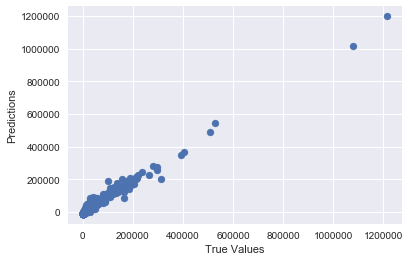

In [124]:
predictions = model_desmoines.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()

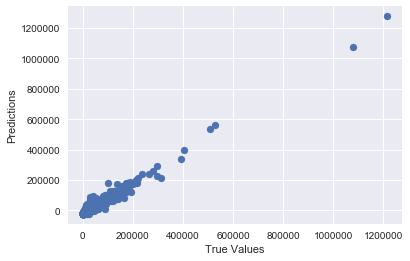

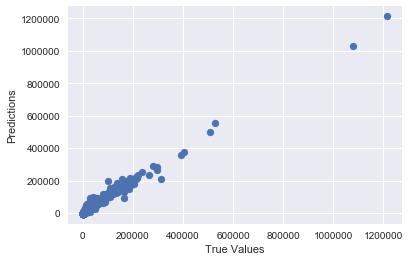

In [125]:
predictions = model_50314.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()


predictions = model_50320.predict(X)

plt.scatter(y, predictions)
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [140]:
liquor_full = pd.read_csv('../../../../Iowa_Liquor_Sales_reduced.csv', dtype=str)[['Store Number',
               'City',
               'Zip Code',
               'County',
               'State Bottle Retail', 
               'Bottles Sold', 
               'Sale (Dollars)']]


In [164]:

## Reformat column names to replace spaces with underscores
liquor_full.columns = [c.replace(' ', '_') for c in liquor_full.columns]
liquor_full.columns = [c.replace(')', '') for c in liquor_full.columns]
liquor_full.columns = [c.replace('(', '') for c in liquor_full.columns]

## turn to lowercase because I hate initcap
liquor_full.columns = [c.lower() for c in liquor_full.columns]


## capitalize city and county for consistency
liquor_full.city = liquor_full.city.str.upper()
liquor_full.county = liquor_full.county.str.upper()

## remove dollar signs and convert to floats
liquor_full['sale_dollars'] = liquor_full['sale_dollars'].str.replace('$','').astype(np.float64)
liquor_full['state_bottle_retail'] = liquor_full['state_bottle_retail'].str.replace('$','').astype(np.float64)
liquor_full['bottles_sold'] = liquor_full['bottles_sold'].astype(np.float64)

# liquor_full.drop_duplicates(inplace=True)
print 'num duplicates:', liquor_full.duplicated().sum()

# ## look into missing county_numbers and counties
county_lookup = liquor_full[['zip_code','county']][liquor_full.county.isnull()==False]
county_lookup.drop_duplicates(inplace=True)


In [143]:

# set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

# push dfs into sql tables
liquor_full.to_sql('liquor_full', engine)
county_lookup.to_sql('county_lookup', engine)
iowa_zips.to_sql('iowa_zips', engine)


# run updates to fill in county names
conn.execute("update liquor_full set county = (select upper(county) from county_lookup where county_lookup.zip_code = liquor_full.zip_code) where county is null;")
conn.execute("update liquor_full set county = (select upper(County) from iowa_zips where iowa_zips.Zip_Code = liquor_full.zip_code) where county is null;")
# run updates to fill in county_numbers
# conn.execute("update liquor_full set county_number = (select county_number from county_lookup where county_lookup.zip_code = liquor_full.zip_code and county_lookup.county = liquor_full.county) where county_number is null;")
liquor_full_sql = pd.read_sql_table('liquor_full',engine)
# close sql connection
conn.close()

eda(liquor_full_sql)

liquor_full_sql['zip_code'][liquor_full_sql.county.isnull()==True]
liquor_full = liquor_full_sql



missing values 
index                  0
store_number           0
city                   0
zip_code               0
county                 0
state_bottle_retail    0
bottles_sold           0
sale_dollars           0
dtype: int64

dataframe types 
index                    int64
store_number            object
city                    object
zip_code                object
county                  object
state_bottle_retail    float64
bottles_sold            object
sale_dollars           float64
dtype: object

dataframe shape 
(2709552, 8)

dataframe describe 
              index  state_bottle_retail  sale_dollars
count  2.709552e+06         2.709552e+06  2.709552e+06
mean   1.354776e+06         1.474012e+01  1.291191e+02
std    7.821804e+05         2.235953e+01  3.994615e+02
min    0.000000e+00         1.340000e+00  1.340000e+00
25%    6.773878e+05         8.270000e+00  3.048000e+01
50%    1.354776e+06         1.230000e+01  7.056000e+01
75%    2.032163e+06         1.794000e+01  1.350000e+02

In [165]:

liquor_full_desmoines = liquor_full[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor_full.city=='DES MOINES'].groupby(liquor_full.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                             'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X_full_desmoines = liquor_full_desmoines[['bottles_sold','state_bottle_retail']]
y_full_desmoines = liquor_full_desmoines['sale_dollars']



liquor_full_50314 = liquor_full[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor_full.zip_code=='50314'].groupby(liquor_full.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X_full_50314 = liquor_full_50314[['bottles_sold','state_bottle_retail']]
y_full_50314 = liquor_full_50314['sale_dollars']

liquor_full_50320 = liquor_full[['store_number',
                           'bottles_sold', 
                           'state_bottle_retail', 
                           'sale_dollars']][liquor_full.zip_code=='50320'].groupby(liquor_full.store_number).agg({'bottles_sold': np.sum,
                                                                                                         'state_bottle_retail' : np.sum, 
                                                                                                         'sale_dollars' : np.sum})
X_full_50320 = liquor_full_50320[['bottles_sold','state_bottle_retail']]
y_full_50320 = liquor_full_50320['sale_dollars']

In [166]:
# run full data set for Des Moines and the two zipcodes on the models built on the reduced 10% data
print model_desmoines.score(X_full_desmoines,y_full_desmoines)
print model_50314.score(X_full_50314,y_full_50314)
print model_50320.score(X_full_50320,y_full_50320)

0.981662131529
0.995911502401
0.998313050465


In [173]:
liquor_full_by_store = liquor_full[['store_number',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail']].groupby(liquor_full.store_number).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum})

X = liquor_full_by_store[['bottles_sold','state_bottle_retail']]
y = liquor_full_by_store['sale_dollars']
print model_by_store.score(X,y)
print model_by_store.alpha_
print ''
liquor_full_by_store['predictions'] = model_by_store.predict(X)
print 'TOP PERFORMING STORES'
liquor_full_by_store[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]


# results with the test data for top stores by performance:
# 2633	1214597.96	1.176886e+06
# 4829	1078334.81	1.001242e+06
# 2512	527274.22	5.406449e+05
# 3385	506589.09	4.880430e+05
# 3420	402576.06	3.646401e+05
# 3952	390158.35	3.438443e+05


# yay it matches the full set!! 

0.969850768125
1344978.94051

TOP PERFORMING STORES


,sale_dollars,predictions
store_number,,
2633,1.228265e+07,1.151508e+07
4829,1.108553e+07,1.015707e+07
2512,5.206377e+06,5.504713e+06
3385,4.759188e+06,4.592834e+06
3420,4.018415e+06,3.510523e+06
3952,3.768333e+06,3.387537e+06
2670,3.015680e+06,3.012344e+06
5102,2.557579e+06,2.796838e+06
3354,2.920467e+06,2.663687e+06


In [178]:

liquor_full_by_zip = liquor_full[['zip_code',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor_full.zip_code).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                                   'store_number' : lambda x: x.nunique()})
liquor_full_by_city = liquor_full[['city',
                          'sale_dollars',
                          'bottles_sold', 
                          'state_bottle_retail',
                        'store_number']].groupby(liquor.city).agg({'sale_dollars' : np.sum,
                                                                                    'bottles_sold' : np.sum,
                                                                                    'state_bottle_retail' : np.sum,
                                                                           'store_number' : lambda x: x.nunique()})


X = liquor_full_by_zip[['bottles_sold','state_bottle_retail']]
y = liquor_full_by_zip['sale_dollars']
print model_zip.score(X,y)
print model_zip.alpha_
print ''
liquor_full_by_zip['predictions'] = model_zip.predict(X)
print 'TOP PERFORMING ZIPS'
print liquor_full_by_zip[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]


X = liquor_full_by_city[['bottles_sold','state_bottle_retail']]
y = liquor_full_by_city['sale_dollars']
print model_by_city.score(X,y)
print model_by_city.alpha_
print ''
liquor_full_by_city['predictions'] = model_by_city.predict(X)
print 'TOP PERFORMING CITIES'
print liquor_full_by_city[['sale_dollars','predictions']].sort_values('predictions', ascending=False)[0:20]



0.976179985154
6624280.86363

TOP PERFORMING ZIPS
          sale_dollars   predictions
zip_code                            
50314     1.352982e+07  1.202532e+07
52402     1.125460e+07  1.170125e+07
52240     1.106181e+07  1.127014e+07
50320     1.312019e+07  1.103642e+07
50010     9.090596e+06  8.738001e+06
51501     6.998685e+06  7.330547e+06
50703     4.671745e+06  6.785124e+06
52807     7.504745e+06  6.732219e+06
52001     6.395593e+06  6.476215e+06
50613     6.257773e+06  6.342994e+06
50311     6.915971e+06  6.306530e+06
52722     6.632695e+06  5.963441e+06
50317     4.420838e+06  5.917337e+06
50702     5.339281e+06  5.732062e+06
52804     4.903297e+06  5.718866e+06
52404     4.780601e+06  5.680539e+06
52241     6.854789e+06  5.670584e+06
50401     4.842734e+06  5.295362e+06
50266     7.214257e+06  5.265494e+06
50265     5.183613e+06  5.104059e+06
0.994125197863
9380074.72554

TOP PERFORMING CITIES
                 sale_dollars   predictions
city                                    